In [16]:
### AAE 722 Lab 10 - Charles Voigt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchinfo import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pathlib import Path
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Set seed after imports
seed_everything(57, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 57


In [3]:
#Question 1 Part A
wage = load_data('Wage')
model = MS(wage[['year', 'age', 'education', 'jobclass']], intercept=False)
X = model.fit_transform(wage[['year', 'age', 'education', 'jobclass']]).to_numpy()
y = wage[['wage']].to_numpy()



(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=57)

scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
#Question 1 Part A continued
X_train_t = torch.tensor(X_train.astype(np.float32)) # Convert training features to PyTorch tensor.
y_train_t = torch.tensor(y_train.astype(np.float32)) # Convert training targets to PyTorch tensor.
wage_train = TensorDataset(X_train_t, y_train_t) # Create a TensorDataset for training data.

X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
wage_test = TensorDataset(X_test_t, y_test_t)

max_num_workers = rec_num_workers() 

wage_dm = SimpleDataModule(wage_train,
                          wage_test,
                          batch_size=64,
                          num_workers=min(4, max_num_workers),
                          validation=wage_test)

In [5]:
#Question 1 Part A Continued
# Print shapes of one training batch
train_loader = wage_dm.train_dataloader()
X_, Y_ = next(iter(train_loader))
print(f"Shape of X_ (input batch): {X_.shape}")
print(f"Shape of Y_ (target batch): {Y_.shape}")

Shape of X_ (input batch): torch.Size([64, 4])
Shape of Y_ (target batch): torch.Size([64, 1])


In [6]:
#Question 1 Part B
class WageModel(nn.Module):
    def __init__(self, input_dim):
        super(WageModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x
    
input_dim = X_train.shape[1] 
model = WageModel(input_dim)
summary(model, input_size=(64, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
WageModel                                [64, 1]                   --
├─Linear: 1-1                            [64, 64]                  320
├─ReLU: 1-2                              [64, 64]                  --
├─Dropout: 1-3                           [64, 64]                  --
├─Linear: 1-4                            [64, 32]                  2,080
├─ReLU: 1-5                              [64, 32]                  --
├─Dropout: 1-6                           [64, 32]                  --
├─Linear: 1-7                            [64, 1]                   33
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

In [7]:
#Question 1 Part C
wage_module = SimpleModule.regression(model, metrics={'mae':MeanAbsoluteError()})
wage_logger = CSVLogger('logs', name='wage_model')

wage_trainer = Trainer(deterministic=True,
                      max_epochs=100,
                      log_every_n_steps=5,
                      logger=wage_logger,
                      callbacks=[ErrorTracker()]) # Configure the PyTorch Lightning Trainer with specified settings. 
wage_trainer.fit(wage_module, datamodule=wage_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | WageModel | 2.4 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
#Question 1 Part C Continued
wage_trainer.test(wage_module, datamodule=wage_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      1242.2998046875      │
│         test_mae          │    23.757221221923828     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1242.2998046875, 'test_mae': 23.757221221923828}]

##### Question 1 Part C Discussion 
The test MAE is 17434.07

In [9]:
#Question 1 Part D
log_path = Path(wage_logger.log_dir) / 'metrics.csv'
wage_results = pd.read_csv(log_path)

def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20): # Function to plot training and validation metrics over epochs. 
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]): # Iterate over training and validation metrics to plot them.
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax) # Plot the specified metric for training and validation.
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

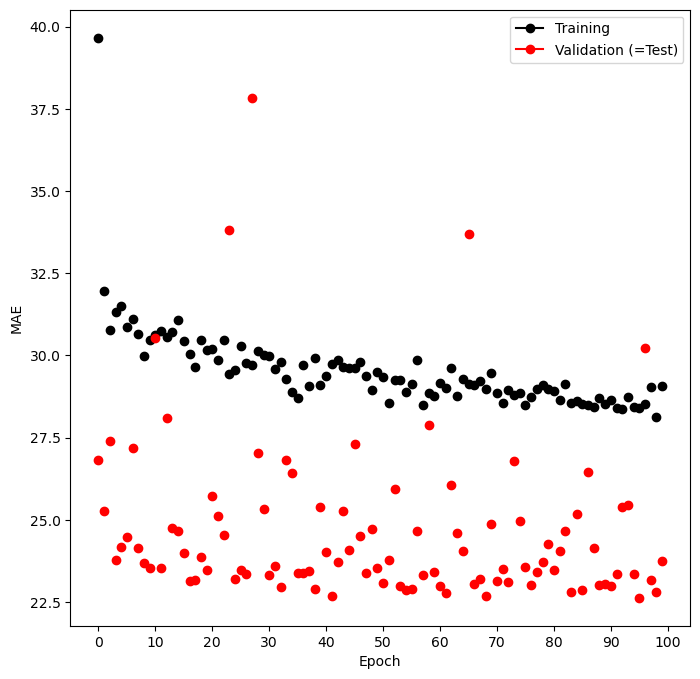

In [10]:
#Question 1 Part D continued
fig, ax = subplots(1, 1, figsize=(8, 8))
ax = summary_plot(wage_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)') # Plot the Mean Absolute Error (MAE) over epochs for training and validation datasets.
ax.set_xticks(np.linspace(0, 100, 11).astype(int));

#### Question 1 Part D Discussion
From the graph, it looks like the model generalizes well, because the validation MAEs are generally lower than the training MAEs.

In [26]:
#Question 2 Part A
from torchvision.transforms import ToTensor

train_path = r'C:\Users\cvoig\Documents\GitHub\2025AAE722_CharlesVoigt\cats_vs_dogs_dataset\train'
test_path = r'C:\Users\cvoig\Documents\GitHub\2025AAE722_CharlesVoigt\cats_vs_dogs_dataset\test'

# Define transformation to convert images to tensors
transform = ToTensor()

# Load datasets using ImageFolder
cvd_train_raw = ImageFolder(root=train_path, transform=transform)
cvd_test_raw = ImageFolder(root=test_path, transform=transform)

# Extract all images and labels into tensors
cvd_train_X = torch.stack([img for img, _ in cvd_train_raw])
cvd_train_y = torch.tensor([label for _, label in cvd_train_raw])

cvd_test_X = torch.stack([img for img, _ in cvd_test_raw])
cvd_test_y = torch.tensor([label for _, label in cvd_test_raw])

# Create TensorDatasets
cvd_train = TensorDataset(cvd_train_X, cvd_train_y)
cvd_test = TensorDataset(cvd_test_X, cvd_test_y)

# Wrap into SimpleDataModule with validation split
max_num_workers = rec_num_workers()

cvd_dm = SimpleDataModule(cvd_train,
                          cvd_test,
                          batch_size=64,
                          num_workers=0, 
                          validation=0.25)  # 25% validation split from training data

for idx, (X_ ,Y_) in enumerate(cvd_dm.train_dataloader()): # Iterate through the training dataloader.
    print('X: ', X_.shape) # Display the shape of the input batch.
    print('Y: ', Y_.shape) # Display the shape of the target batch.
    if idx >= 1: # Stop after printing the first batch.
        break

X:  torch.Size([64, 3, 64, 64])
Y:  torch.Size([64])
X:  torch.Size([64, 3, 64, 64])
Y:  torch.Size([64])


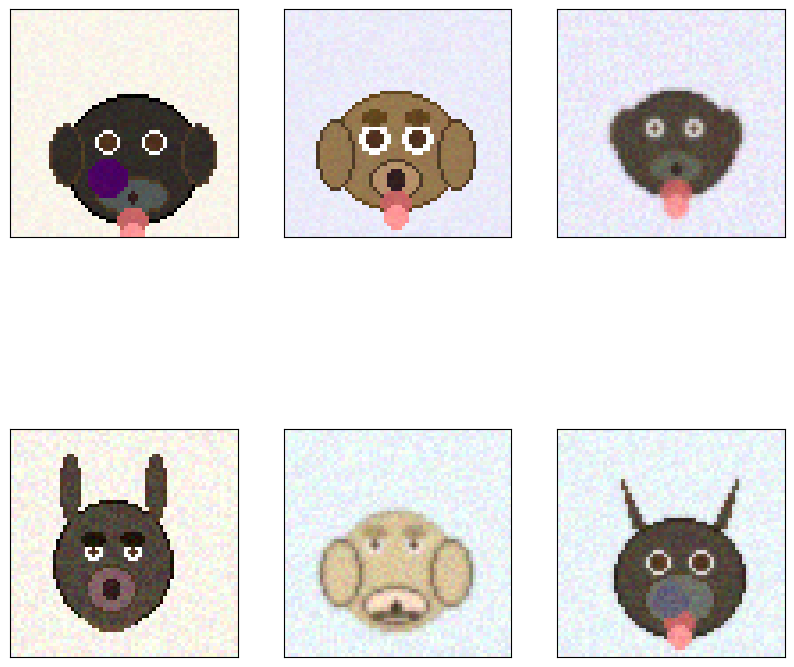

In [27]:
#Question 2 Part A Continued
fig, axes = subplots(2, 3, figsize=(10,10)) 
rng = np.random.default_rng(4) 
indices = rng.choice(np.arange(len(cvd_train)), 6,
                     replace=False).reshape((2,3)) # Select 6 random indices from the training dataset without replacement and reshape them into a 2x3 array for visualization.
for i in range(2): # Iterate over the rows of the 2x3 grid.
    for j in range(3): # Iterate over the columns of the 2x3 grid.
        idx = indices[i,j] # Get the index of the image to display.
        axes[i,j].imshow(np.transpose(cvd_train[idx][0], 
                                      [1,2,0]),
                                      interpolation=None) # Display the image at the selected index.
        axes[i,j].set_xticks([]) # Remove x-axis ticks for cleaner visualization.
        axes[i,j].set_yticks([]) # Remove y-axis ticks for cleaner visualization.